# Task 3. Algorithms for unconstrained nonlinear optimization. First- and second- order methods

In [236]:
import matplotlib.pyplot as plt
from collections.abc import Callable
from functools import partial
import numpy as np
import pandas as pd

In [237]:
import json

with open('./../2/points.json') as file:
    content = json.loads(file.read())
    alpha = content['alpha']
    beta = content['beta']
    y = content['y']

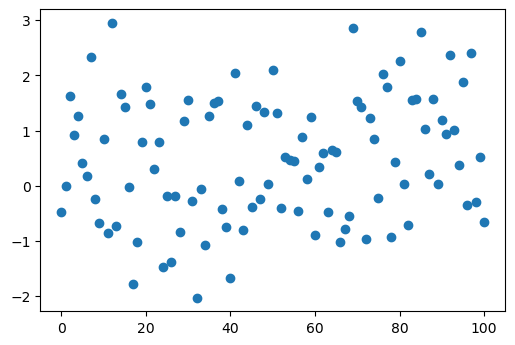

In [238]:
n = 101

x = [x_k for x_k in range(n)]

fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)

In [239]:
def linear(x: float, a: float, b: float) -> float:
    return a * x + b

def rational(x: float, a: float, b: float) -> float:
    return a / (1 + b * x)

In [240]:
def least_squares(args, fn: Callable):
    return sum([np.power(fn(x[i], args[0], args[1]) - y[i], 2) for i in range(n)])

In [241]:
from scipy.optimize import minimize
import math

def gradient_descent(fn: Callable, gradient: Callable, x0, epsilon: float = 0.001):
    a, b = x0
    a_old, b_old = a, b
    df_da, df_db = 1, 1
    iters = 0
    f_calculations = 0

    while (math.fabs((fn(a, b) - fn(a_old, b_old)) / 2)) > epsilon or iters == 0:
        f_calculations += 2
        df_da_old, df_db_old = df_da, df_db
        df_da, df_db = gradient(a, b)
        if iters == 0:
            lr = 0.001
        else:
            f1 = (np.array([a, b] - np.array([a_old, b_old])))
            f2 = (np.array([df_da, df_db] - np.array([df_da_old, df_db_old])))
            lr = np.mean(np.abs(f1 * f2) / (f2 ** 2))
        a_old, b_old = a, b
        a -= lr * df_da
        b -= lr * df_db
        
        iters += 1

    return a, b, iters, f_calculations

In [242]:
def least_squares_linear_gradient(a: float, b: float) -> (float, float):
    temp_a = []
    temp_b = []
    for k in range(n):
        x = k / n
        y_i = y[k]
        temp_a.append(2 * x ** 2 * a + 2 * b * x - 2 * y_i * x)
        temp_b.append(2 * b + 2 * a * x - 2 * y_i)
    df_da = sum(temp_a)
    df_db = sum(temp_b)
    
    return df_da, df_db

least_squares_linear = lambda a, b: sum([(linear(k / n, a, b) - x[k]) ** 2 for k in range(n)])

gd_result = gradient_descent(least_squares_linear, least_squares_linear_gradient, (0, 0))
gd_a = gd_result[0]
gd_b = gd_result[1]

gd_result

(0.6244035304808928, 0.17317992519878223, 21, 42)

In [243]:
def conjugate_gradient(fn: Callable, args, x0, epsilon: float = 0.001):
    return minimize(
        fn,
        x0=x0,
        method='CG',
        args=(args,),
        tol=epsilon
    )

In [244]:
cg_result = conjugate_gradient(least_squares, linear, (0, 0))
cg_a = cg_result.x[0]
cg_b = cg_result.x[1]

In [245]:
from autograd import jacobian

def newtons_method(fn: Callable, args, x0, epsilon: float = 0.001):
    return minimize(
        fn,
        x0=x0,
        method='Newton-CG',
        args=(args,),
        jac=jacobian(fn),
        tol=epsilon
    )

In [246]:
nm_result = newtons_method(least_squares, linear, (0, 0))
nm_a = nm_result.x[0]
nm_b = nm_result.x[1]

In [247]:
from scipy.optimize import curve_fit

def levenberg_marquardt(fn: Callable, x: list[float], y: list[float]):
    return curve_fit(
        fn,
        xdata=x,
        ydata=y,
        method='lm'
    )

In [248]:
lm_result = levenberg_marquardt(linear, x, y)

lm_a = lm_result[0][0]
lm_b = lm_result[0][1]

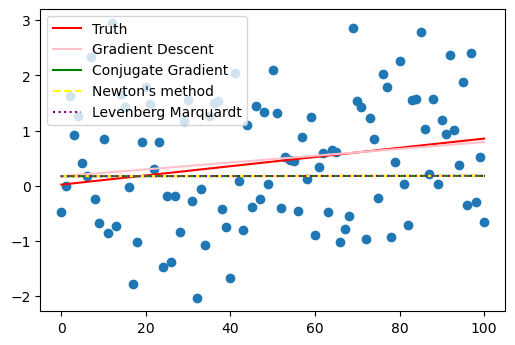

In [249]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
    
ax.scatter(range(n), y, zorder=1)
ax.plot(range(n), [linear(x / n, alpha, beta) for x in range(n)], color='red', label="Truth")
ax.plot(range(n), [linear(x / n, gd_a, gd_b) for x in range(n)], color='pink', label='Gradient Descent')
ax.plot(range(n), [linear(x / n, cg_a, cg_b) for x in range(n)], color='green', label='Conjugate Gradient')
ax.plot(range(n), [linear(x / n, nm_a, nm_b) for x in range(n)], color='yellow', linestyle='dashed', label='Newton\'s method')
ax.plot(range(n), [linear(x / n, lm_a, lm_b) for x in range(n)], color='purple', linestyle='dotted', label='Levenberg Marquardt')
ax.legend(loc='upper left')

In [250]:
pd.DataFrame(
    [
        ['Gradient Descent', gd_a, gd_b, gd_result[2], gd_result[3]],
        ['Conjugate Gradient', cg_a, cg_b, cg_result.nit, cg_result.nfev],
        ['Newton\'s method', nm_a, nm_b, nm_result.nit, nm_result.nfev],
        ['Levenberg-Marquardt', lm_a, lm_b, 'n/a', 'n/a']
    ],
    columns=['Method', '$a_{min}$', '$b_{min}$', 'Iterations', 'F-Calculations']
)

,Method,$a_{min}$,$b_{min}$,Iterations,F-Calculations
0,Gradient Descent,0.624404,0.173180,21,42
1,Conjugate Gradient,0.006182,0.173181,2,15
2,Newton's method,0.006182,0.173179,2,24
3,Levenberg-Marquardt,0.006182,0.173179,n/a,n/a


In [251]:
def least_squares_rational_gradient(a, b) -> (float, float):
    temp_a = []
    temp_b = []
    for k in range(n):
        x = (k / n)
        y_i = (y[k])

        a_denominator = (1 + b * x) ** 2
        temp_a.append(
            - ((2 * x * b * y_i) / a_denominator)
            + (2 * a / a_denominator)
            - (2 * y_i / a_denominator)
        )

        temp_b.append(
            -(2 * a * x * (a - y_i - x * b * y_i))
            / ((b * x + 1) ** 3)
        )
    df_da = sum(temp_a)
    df_db = sum(temp_b)
    
    return df_da, df_db

least_squares_rational = lambda a, b: sum([(rational(k / n, a, b) - x[k]) ** 2 for k in range(n)])

gd_result = gradient_descent(least_squares_rational, least_squares_rational_gradient, (0, 0))
gd_a = gd_result[0]
gd_b = gd_result[1]

gd_result

(0.27791101229014503, -0.7203379434468451, 43, 86)

In [252]:
cg_result = conjugate_gradient(least_squares, rational, (0, 0))
cg_a = cg_result.x[0]
cg_b = cg_result.x[1]

In [253]:
nm_result = newtons_method(least_squares, rational, (0, 0))
nm_a = nm_result.x[0]
nm_b = nm_result.x[1]

In [254]:
lm_result = levenberg_marquardt(rational, x, y)

lm_a = lm_result[0][0]
lm_b = lm_result[0][1]

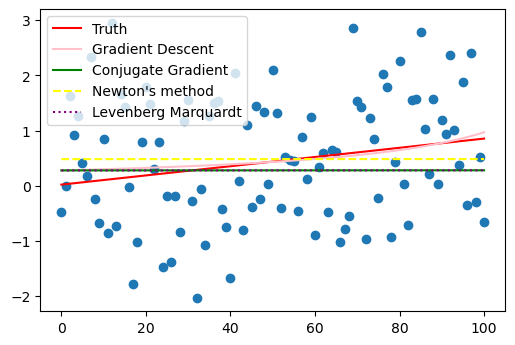

In [255]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)
    
ax.scatter(range(n), y, zorder=1)
ax.plot(range(n), [linear(x / n, alpha, beta) for x in range(n)], color='red', label="Truth")
ax.plot(range(n), [rational(x / n, gd_a, gd_b) for x in range(n)], color='pink', label='Gradient Descent')
ax.plot(range(n), [rational(x / n, cg_a, cg_b) for x in range(n)], color='green', label='Conjugate Gradient')
ax.plot(range(n), [rational(x / n, nm_a, nm_b) for x in range(n)], color='yellow', linestyle='dashed', label='Newton\'s method')
ax.plot(range(n), [rational(x / n, lm_a, lm_b) for x in range(n)], color='purple', linestyle='dotted', label='Levenberg Marquardt')
ax.legend(loc='upper left')

In [256]:
pd.DataFrame(
    [
        ['Gradient Descent', gd_a, gd_b, gd_result[2], gd_result[3]],
        ['Conjugate Gradient', cg_a, cg_b, cg_result.nit, cg_result.nfev],
        ['Newton\'s method', nm_a, nm_b, nm_result.nit, nm_result.nfev],
        ['Levenberg-Marquardt', lm_a, lm_b, 'n/a', 'n/a']
    ],
    columns=['Method', '$a_{min}$', '$b_{min}$', 'Iterations', 'F-Calculations']
)

,Method,$a_{min}$,$b_{min}$,Iterations,F-Calculations
0,Gradient Descent,0.277911,-0.720338,43,86
1,Conjugate Gradient,0.277895,-0.007132,14,214
2,Newton's method,0.482233,-0.003426,3,8
3,Levenberg-Marquardt,0.277893,-0.007132,n/a,n/a
